# eda

In [3]:
import polars as pl
from pathlib import Path
from plotnine import ggplot, aes, geom_histogram, labs, theme_minimal, geom_bar, theme_tufte,theme, element_blank, xlab, ylab, element_text
import pyarrow as pa

In [4]:
data_path = Path('data')
train = pl.read_csv(data_path / 'train_values.csv')
labels = pl.read_csv(data_path / 'train_labels.csv')

- slightly unclear why labs with <3, <5 and <10 sequences exist
- one class has > 8000 sequences, this should be "Unknown Engineered" but also a bit unclear

/var/folders/8v/x8y04ch95qnb55sh9sh78mmh0000gn/T/ipykernel_13404/3804795683.py:2: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


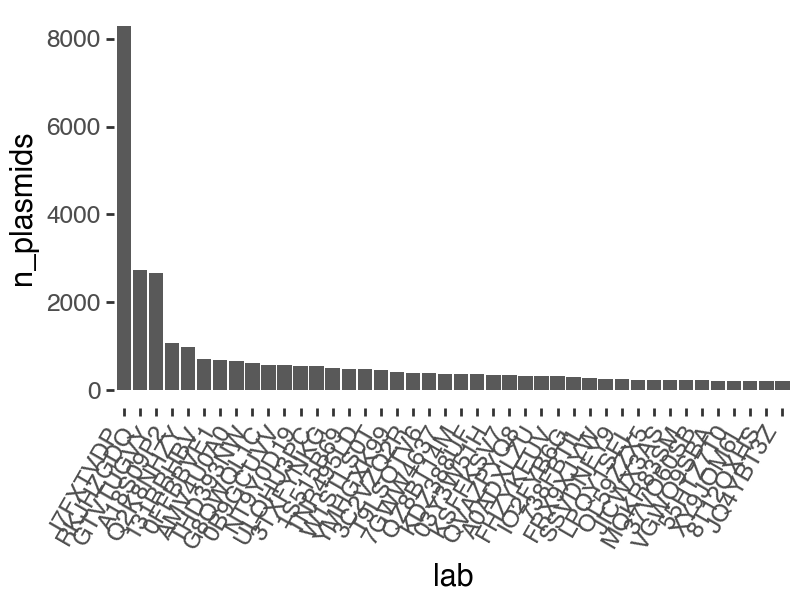

In [5]:
(labels.select(pl.exclude("sequence_id").sum())
    .melt(variable_name="lab", value_name="value")
    .filter(pl.col("value") > 200)
    .sort("value", descending=True)
    .pipe(lambda df: ggplot(df, aes(y="value", x="reorder(lab, -value)")) +
        geom_bar(stat="identity") +
        theme_tufte() +
        theme(axis_text_x=element_text(rotation=60, hjust=1),
              figure_size=(4,3)) +
        xlab("lab") +
        ylab("n_plasmids")
    )
)


- a peak of short sequences, followed by a normal distribution of longer ones

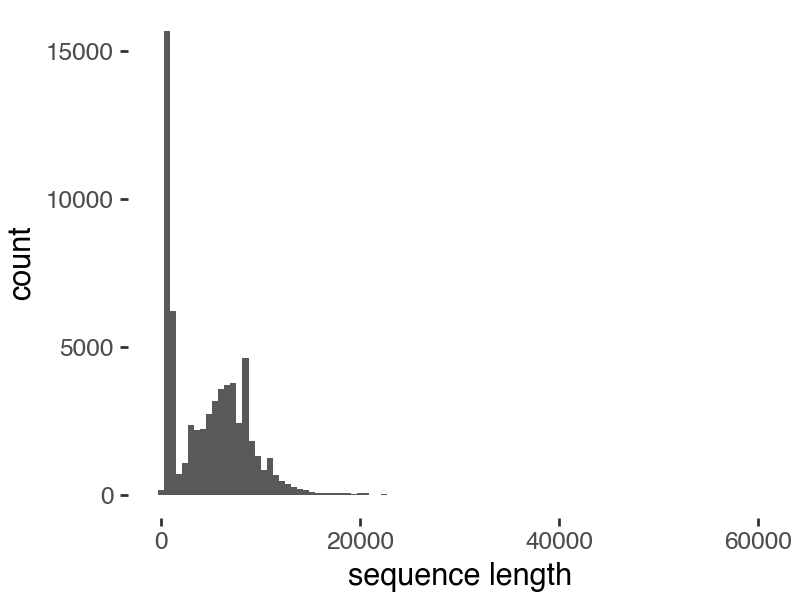

In [6]:
(train
    .with_columns(seqlen = pl.col("sequence").str.len_chars())
    .pipe(lambda s: ggplot(s, aes(x="seqlen")) +
        geom_histogram(bins=100)) +
        theme_tufte() +
        theme(figure_size=(4,3)) +
        xlab("sequence length") 
)

## Preprocessing

- replace everything that's not ATGCN with N
- truncate to 8000
- pad shorter sequences with "N"

In [7]:
train = train.with_columns(
         pl.col("sequence")
        .str.replace_all(r"[^ATGCN]", "N")
        .str.slice(0, 8000)
        .str.pad_end(8000, "N")
    )

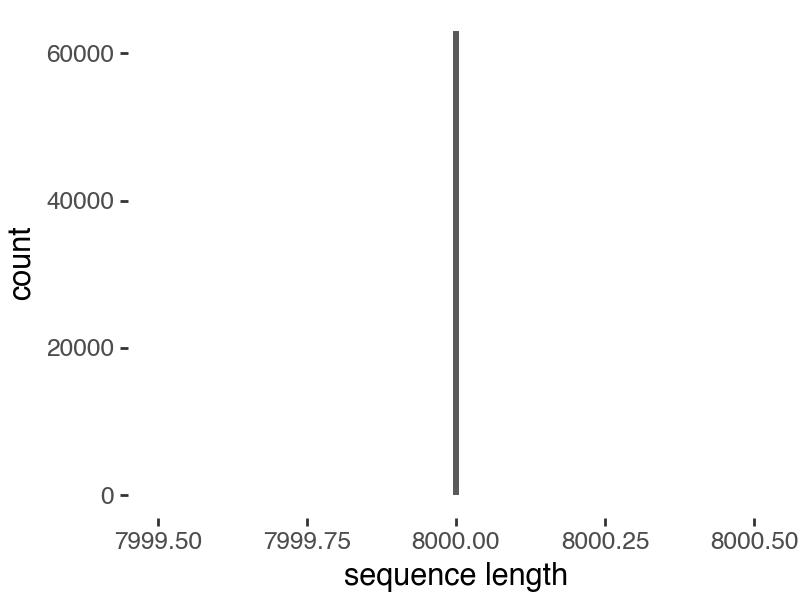

In [8]:
# check that it worked
(train
    .with_columns(seqlen = pl.col("sequence").str.len_chars())
    .pipe(lambda s: ggplot(s, aes(x="seqlen")) +
        geom_histogram(bins=100)) +
        theme_tufte() +
        theme(figure_size=(4,3)) +
        xlab("sequence length") 
)

In [9]:
# train.write_csv(data_path / 'train_values_processed.csv')

In [ ]:
# count how often 1.0 appears in each column
labs = (labels.melt(id_vars=["sequence_id"])
    .filter(pl.col("value") == 1.0)
    .select([
        pl.col("sequence_id"),
        pl.col("variable").alias("lab")
    ]))

/var/folders/8v/x8y04ch95qnb55sh9sh78mmh0000gn/T/ipykernel_13404/1014932901.py:2: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


In [ ]:
# labs.write_csv(data_path / 'train_labels_processed.csv')

In [ ]:
# check
len(labs) == len(train)

True